# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
import seaborn as sb
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data assesing

In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


Channels can be expanded, so it will be easier to process it in the next step. id must be translated into more numerical categorical value to make it easy to analze.

In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


there are odd value in age, the oldest human in teh world has age 117. Furthermore, with income Nan, it can be infer that data with age 118 is flaw.

In [8]:
profile.shape

(17000, 5)

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


there are null value in gender and income but its size is small. It will not be a problem to delete incomplete data from dataset. It is not proper if became member in int, it must be changed into date.

In [10]:
profile[profile.gender.isnull()]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


All null gender has the same row with 118 years old age. It is enough do delete row with 118 years old age.

In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


value column need to be extracted. 

In [13]:
transcript.shape

(306534, 4)

In [14]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [15]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


### Data assesing summary

1. expand channels column in portofolio data
2. encode id in portofolio data
3. encode id in profile data
4. delete data with age equal to 118 in profile data
5. Change became_member_on column in transcript data into datetime
6. encode id in profile data
7. extract value column in transcript data
8. encode extracted value in transcript data

## Data Cleaning

In [16]:
# copy dataframe
pf_copy = portfolio.copy()
prof_copy = profile.copy()
trans_copy = transcript.copy()

`1. expand channels column in portofolio data`

### Code

In [17]:
pf_copy.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [18]:
# encode channels column
mlb = MultiLabelBinarizer()

encoded_chan = pd.DataFrame(mlb.fit_transform(pf_copy.channels), columns = mlb.classes_)

# join encoded channels with dataframe
pf_copy = (pf_copy.join(encoded_chan)).drop(columns={'channels'})

### Test

In [19]:
pf_copy.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


`2. translate id in portofolio data`

### Code

In [20]:
# make dictionary of portfolio id
portfolio_id = {}

for ind, val in enumerate(list(pf_copy.id.unique())):
    portfolio_id[val] = ind+1

In [21]:
# mapping id based on dictionary
pf_copy.replace({'id':portfolio_id}, inplace = True)

### Test

In [22]:
pf_copy.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,1,bogo,10,1,1,1,0
1,10,5,2,bogo,10,1,1,1,1
2,0,4,3,informational,0,1,1,0,1
3,5,7,4,bogo,5,1,1,0,1
4,20,10,5,discount,5,1,0,0,1


`3. encode id in profile data`

### Code

In [23]:
# make dictionary of portfolio id
prof_id = {}

for ind, val in enumerate(list(prof_copy.id.unique())):
    prof_id[val] = ind+1

In [24]:
# mapping id based on dictionary
prof_copy.replace({'id':prof_id}, inplace = True)

### Test

In [25]:
prof_copy.id.unique()

array([    1,     2,     3, ..., 16998, 16999, 17000])

`4. delete data with age equal to 118 in profile data`

### Code

In [26]:
prof_copy.drop(prof_copy[prof_copy.age==118].index, inplace = True)

### Test

In [27]:
prof_copy[prof_copy.age==118]

,age,became_member_on,gender,id,income


In [28]:
prof_copy.reset_index().drop(columns=['index'])

,age,became_member_on,gender,id,income
0,55,20170715,F,2,112000.0
1,75,20170509,F,4,100000.0
2,68,20180426,M,6,70000.0
3,65,20180209,M,9,53000.0
4,58,20171111,M,13,51000.0
5,61,20170911,F,14,57000.0
6,26,20140213,M,15,46000.0
7,62,20160211,F,16,71000.0
8,49,20141113,M,17,52000.0
9,57,20171231,M,19,42000.0


`5. Change became_member_on column in transcript data into datetime`

### Code

In [29]:
prof_copy['became_member_on'] = prof_copy['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

### Test

In [30]:
prof_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null datetime64[ns]
gender              14825 non-null object
id                  14825 non-null int64
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 694.9+ KB


In [31]:
prof_copy.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,2,112000.0
3,75,2017-05-09,F,4,100000.0
5,68,2018-04-26,M,6,70000.0
8,65,2018-02-09,M,9,53000.0
12,58,2017-11-11,M,13,51000.0


`6. encode id in transcript data`

### Code

In [32]:
# make dictionary of portfolio id
tran_id = {}

for ind, val in enumerate(list(trans_copy.person.unique())):
    tran_id[val] = ind+1

In [33]:
# mapping id based on dictionary
trans_copy.replace({'person':tran_id}, inplace = True)

### Test

In [34]:
trans_copy.head()

,event,person,time,value
0,offer received,1,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,2,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,3,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,4,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,5,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


`7. extract data on value column in transcript data`

### Code

In [35]:
# expand value column
val_trans = trans_copy['value'].apply(pd.Series)
val_trans.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [36]:
len(val_trans[val_trans['offer id'].notnull()])

134002

In [37]:
(val_trans[val_trans['amount'].notnull()])

,offer id,amount,offer_id,reward
12654,NaN,0.83,NaN,NaN
12657,NaN,34.56,NaN,NaN
12659,NaN,13.23,NaN,NaN
12670,NaN,19.51,NaN,NaN
12671,NaN,18.97,NaN,NaN
12678,NaN,33.90,NaN,NaN
12686,NaN,0.22,NaN,NaN
12687,NaN,18.59,NaN,NaN
12691,NaN,18.01,NaN,NaN
12696,NaN,19.11,NaN,NaN


In [38]:
(val_trans[val_trans['offer_id'].notnull()])

,offer id,amount,offer_id,reward
12658,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
12717,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0
12721,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
12744,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0
12764,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12767,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


In [39]:
# mapping offer id based on dictionary
val_trans.loc[np.array(val_trans[val_trans['offer id'].notnull()].index), :] = val_trans.loc[np.array(val_trans[val_trans['offer id'].notnull()].index) , :].replace({'offer id':portfolio_id})
val_trans.loc[np.array(val_trans[val_trans['offer_id'].notnull()].index), :] = val_trans.loc[np.array(val_trans[val_trans['offer_id'].notnull()].index) , :].replace({'offer_id':portfolio_id})

In [40]:
# rejoin trans copy and expanded value column
trans_copy = trans_copy.join(val_trans)

In [41]:
trans_copy.drop(columns = ['value'], inplace = True)

### Test

In [42]:
trans_copy.head()

,event,person,time,offer id,amount,offer_id,reward
0,offer received,1,0,4,NaN,NaN,NaN
1,offer received,2,0,5,NaN,NaN,NaN
2,offer received,3,0,10,NaN,NaN,NaN
3,offer received,4,0,7,NaN,NaN,NaN
4,offer received,5,0,2,NaN,NaN,NaN


In [43]:
val_trans.loc[np.array(val_trans[val_trans['offer id'].notnull()].index), 'offer id'].head()

0     4
1     5
2    10
3     7
4     2
Name: offer id, dtype: object

In [44]:
val_trans.loc[np.array(val_trans[val_trans['offer_id'].notnull()].index), 'offer_id'].head()

12658    10
12672     7
12679     4
12692     1
12697     2
Name: offer_id, dtype: object

### Exploratory Data

In [45]:
# make copy of cleaned data
pf_clean = pf_copy.copy()
prof_clean = prof_copy.copy()
trans_clean = trans_copy.copy()

In [46]:
pf_clean.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,1,bogo,10,1,1,1,0
1,10,5,2,bogo,10,1,1,1,1
2,0,4,3,informational,0,1,1,0,1
3,5,7,4,bogo,5,1,1,0,1
4,20,10,5,discount,5,1,0,0,1


In [47]:
prof_clean.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,2,112000.0
3,75,2017-05-09,F,4,100000.0
5,68,2018-04-26,M,6,70000.0
8,65,2018-02-09,M,9,53000.0
12,58,2017-11-11,M,13,51000.0


In [48]:
trans_clean.head()

,event,person,time,offer id,amount,offer_id,reward
0,offer received,1,0,4,NaN,NaN,NaN
1,offer received,2,0,5,NaN,NaN,NaN
2,offer received,3,0,10,NaN,NaN,NaN
3,offer received,4,0,7,NaN,NaN,NaN
4,offer received,5,0,2,NaN,NaN,NaN


### Profile data exploration

In [49]:
# separate male and female data
f_prof = prof_clean[prof_clean.gender == 'F']
m_prof = prof_clean[prof_clean.gender == 'M']

In [50]:
# amount of male and female customers
[f_prof.shape[0], m_prof.shape[0], m_prof.shape[0] - f_prof.shape[0]]

[6129, 8484, 2355]

In [51]:
[f_prof.age.mean(), m_prof.age.mean()]

[57.544950236580192, 52.11669024045262]

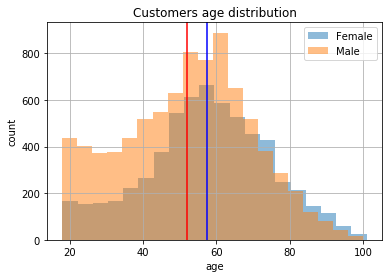

In [52]:
# show age distribution based on female and male customer
f_prof.age.hist(alpha=0.5, bins=20, label = 'Female');
m_prof.age.hist(alpha=0.5, bins=20, label = 'Male');
plt.axvline(f_prof.age.mean(), color='blue');
plt.axvline(m_prof.age.mean(), color='red');
plt.legend();
plt.title('Customers age distribution')
plt.ylabel('count');
plt.xlabel('age');

From the distribution, we can see that female and male customers have similar distribution. But, starbucks male customers is more than female customers and have difference around 2355. Mean age of male customers is around 52.17 years old which is younger than mean age of female customers (57.54 years old).

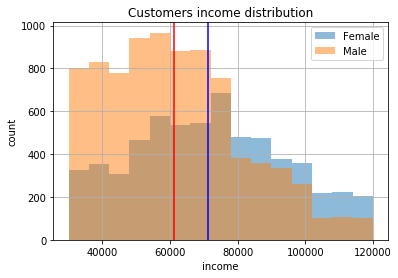

In [53]:
# show income distribution based on female and male customer
f_prof.income.hist(alpha=0.5, bins=15, label = 'Female');
m_prof.income.hist(alpha=0.5, bins=15, label = 'Male');
plt.axvline(f_prof.income.mean(), color='blue');
plt.axvline(m_prof.income.mean(), color='red');
plt.legend();
plt.title('Customers income distribution')
plt.ylabel('count');
plt.xlabel('income');

This plot shows unique result. Mean income female customers is more than mean income female customers. Female income almost in normal distribution, but male customers distribution is skew right.

In [54]:
# grouping became members years
prof_clean['year_member_on'] = pd.DatetimeIndex(prof_clean.became_member_on).year
prof_clean.head()

,age,became_member_on,gender,id,income,year_member_on
1,55,2017-07-15,F,2,112000.0,2017
3,75,2017-05-09,F,4,100000.0,2017
5,68,2018-04-26,M,6,70000.0,2018
8,65,2018-02-09,M,9,53000.0,2018
12,58,2017-11-11,M,13,51000.0,2017


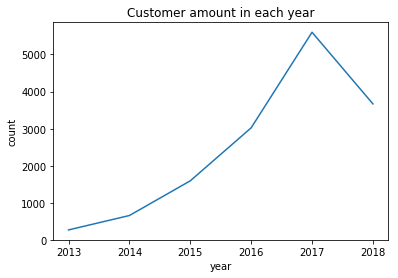

In [55]:
prof_clean.groupby('year_member_on')['id'].count().plot(kind='line');
plt.title('Customer amount in each year');
plt.ylabel('count');
plt.xlabel('year');

By the time pass, starbucks customers increasing except in the last year. It needs further investigation in 2018 to gain more information.

In [56]:
year2018 = prof_clean[prof_clean.year_member_on == 2018]
year2018['month'] =  pd.DatetimeIndex(year2018.became_member_on).month
year2018.describe()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,id,income,year_member_on,month
count,3669.000000,3669.000000,3669.000000,3669.0,3669.000000
mean,53.235759,8501.182884,61853.638594,2018.0,3.806759
std,17.570493,4836.729851,20306.205598,0.0,2.027482
min,18.000000,6.000000,30000.000000,2018.0,1.000000
25%,41.000000,4372.000000,46000.000000,2018.0,2.000000
50%,54.000000,8497.000000,60000.000000,2018.0,4.000000
75%,66.000000,12740.000000,74000.000000,2018.0,6.000000
max,100.000000,16997.000000,120000.000000,2018.0,7.000000


It reveals that why customer who become starbucks customer in 2018 is less than previous year. Data only taken until July, so it still has potention to increase until the end of year. 

### Transcript data exploration

In [57]:
trans_clean.head()

,event,person,time,offer id,amount,offer_id,reward
0,offer received,1,0,4,NaN,NaN,NaN
1,offer received,2,0,5,NaN,NaN,NaN
2,offer received,3,0,10,NaN,NaN,NaN
3,offer received,4,0,7,NaN,NaN,NaN
4,offer received,5,0,2,NaN,NaN,NaN


In [58]:
trans_clean.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

There are 4 types of event in transcript data. Showing amount of event count will give us information about funneling in campaign without considering type of campaign in the first exploration.

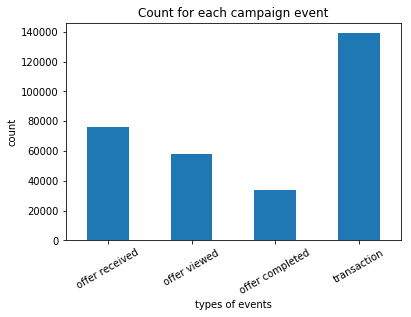

In [59]:
# get base color
base_col = sb.color_palette()[0]

order_event = ['offer received', 'offer viewed', 'offer completed', 'transaction']

trans_clean.groupby('event').person.count().loc[order_event].plot(kind='bar', color = base_col);
plt.title('Count for each campaign event');
plt.xlabel('types of events');
plt.xticks(rotation=30)
plt.ylabel('count');

In [60]:
# calculate probability of campaign is viewed
trans_clean.groupby('event').person.count().loc[order_event][1]/ trans_clean.groupby('event').person.count().loc[order_event][0]

0.75678120534368154

In [61]:
# calculate probability of campaign is completed
trans_clean.groupby('event').person.count().loc[order_event][2]/ trans_clean.groupby('event').person.count().loc[order_event][0]

0.4402244451145168

based on graph above, amount in offer received, offer viewed and offer completed is decreasing. But, from this graph we can calculate funneling process in campaign. About 75.67% of campaign is viewed by user and 44.02% campaign is completed. This information can be used for cost vs profit analysis from campaign.

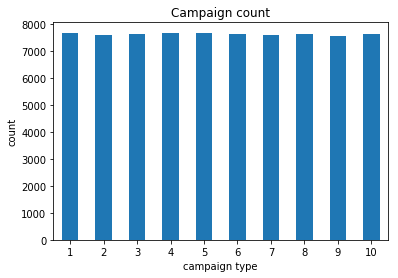

In [62]:
trans_offer = trans_clean[trans_clean.event == "offer received"]

trans_offer[trans_offer['offer id'].notnull()].groupby('offer id')['person'].count().plot(kind='bar', color = base_col);
plt.title('Campaign count');
plt.xlabel('campaign type');
plt.ylabel('count');
plt.xticks(rotation=0);

In [63]:
trans_offer[trans_offer['offer id'].notnull()].groupby('offer id')['person'].count()

offer id
1     7658
2     7593
3     7617
4     7677
5     7668
6     7646
7     7597
8     7618
9     7571
10    7632
Name: person, dtype: int64

All campaign are sent into around 7500 - 7600 thousand customers. Data from each campaign slight difference, so it is okay to compare all campaign.

### Business Question

From data exploration, I can make several business question that can be used by starbucks to enhance their business and there are :
1. Which campaign type that is the most effective?
2. Which customer segment that give good response to campaign?

### Explanatory Data

`1. Which campaign type that is the most effective?`

In [64]:
# copy data for explanatory process
exp_trans = trans_clean
exp_prof = prof_clean
exp_pf = pf_clean

In [65]:
exp_trans = exp_trans.fillna(0)

In [66]:
exp_trans['offer id'] = exp_trans['offer id'] + exp_trans['offer_id']

In [67]:
exp_trans.head()

,event,person,time,offer id,amount,offer_id,reward
0,offer received,1,0,4,0.0,0,0.0
1,offer received,2,0,5,0.0,0,0.0
2,offer received,3,0,10,0.0,0,0.0
3,offer received,4,0,7,0.0,0,0.0
4,offer received,5,0,2,0.0,0,0.0


In [68]:
# grouping and counting offer received each person and offer id
sorted_offer = exp_trans[exp_trans['event'] == 'offer received'].groupby(['person', 'offer id']).count()['event'].reset_index()
sorted_offer.rename(columns = {'event':'offer_received'}, inplace =True)

In [69]:
# grouping and counting offer viewed each person and offer id
sorted_view = exp_trans[exp_trans['event'] == 'offer viewed'].groupby(['person', 'offer id']).count()['event'].reset_index()
sorted_view.rename(columns = {'event':'offer_viewed'}, inplace =True)

In [70]:
# grouping and counting offer completed each person and offer id
sorted_comp = exp_trans[exp_trans['event'] == 'offer completed'].groupby(['person', 'offer id']).count()['event'].reset_index()
sorted_comp.rename(columns = {'event':'offer_completed'}, inplace =True)

In [71]:
# merged dataframe and fill na with 0
camp_pl = pd.merge(sorted_offer, sorted_view,  how='left', left_on= ['person', 'offer id'], right_on = ['person', 'offer id'])
camp_pl = pd.merge(camp_pl, sorted_comp,  how='left', left_on= ['person', 'offer id'], right_on = ['person', 'offer id'])
camp_pl = camp_pl.fillna(0)
camp_pl = camp_pl.astype({'offer_viewed': 'int', 'offer_completed': 'int'})

In [72]:
#  find success percentage of each offer
pipeline_offer = camp_pl.groupby('offer id').sum().reset_index()[['offer id','offer_received', 'offer_viewed', 'offer_completed']]
pipeline_offer['exactly_completed'] = pd.DataFrame([pipeline_offer['offer_viewed'], pipeline_offer['offer_completed']]).min()
pipeline_offer['complete_percentage'] = pipeline_offer['exactly_completed'] / pipeline_offer['offer_received']*100

In [73]:
pipeline_offer.complete_percentage

0    48.158788
1    43.869353
2     0.000000
3    54.331119
4    34.728743
5    67.433952
6    69.988153
7     0.000000
8    56.742835
9    52.633648
Name: complete_percentage, dtype: float64

From table above, we can know completed percentage of each offer. It is simple to sort value and get which offer has the highest conversion rate, but it will take a long time to prove with statistically significant. Used K means clustering for 10 offers to reduce number of items to compare. All offers will be grouped into 4 clusters, and then we can calculate the statistically significancy for the best converted offers group

In [74]:
data_to_clust = (pipeline_offer.complete_percentage/100).reset_index()
data_to_clust['bias'] = 0
data_to_clust.drop(columns={'index'}, inplace = True)

In [75]:
data_to_clust

,complete_percentage,bias
0,0.481588,0
1,0.438694,0
2,0.000000,0
3,0.543311,0
4,0.347287,0
5,0.674340,0
6,0.699882,0
7,0.000000,0
8,0.567428,0
9,0.526336,0


In [76]:
# make kmeans class
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state=42)
# fit process
kmeans.fit(data_to_clust)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [77]:
# add cluster label into dataframe
pipeline_offer['cluster'] = kmeans.labels_

In [78]:
pipeline_offer

,offer id,offer_received,offer_viewed,offer_completed,exactly_completed,complete_percentage,cluster
0,1,7658,6716,3688,3688,48.158788,2
1,2,7593,7298,3331,3331,43.869353,2
2,3,7617,4144,0,0,0.000000,1
3,4,7677,4171,4354,4171,54.331119,2
4,5,7668,2663,3420,2663,34.728743,2
5,6,7646,7337,5156,5156,67.433952,0
6,7,7597,7327,5317,5317,69.988153,0
7,8,7618,6687,0,0,0.000000,1
8,9,7571,7264,4296,4296,56.742835,2
9,10,7632,4118,4017,4017,52.633648,2


Based on clustering results, offers with highest completed percentage are on cluster 0. Proving this result with statistical significancy.

### A/B test cluster 0 and cluster 1

In [79]:
# calculate complete percentage each cluster
conv_rate_0 = pipeline_offer[pipeline_offer.cluster==0].complete_percentage.mean()/100
conv_rate_1 = pipeline_offer[pipeline_offer.cluster==1].complete_percentage.mean()/100
conv_rate_2 = pipeline_offer[pipeline_offer.cluster==2].complete_percentage.mean()/100

In [80]:
# calculate n_trial for each group
trial_0 = pipeline_offer[pipeline_offer.cluster==0].offer_received.sum()
trial_1 = pipeline_offer[pipeline_offer.cluster==1].offer_received.sum()
trial_2 = pipeline_offer[pipeline_offer.cluster==2].offer_received.sum()

In [81]:
present_mean = conv_rate_0 - conv_rate_1
present_mean

0.68711052805891992

In [82]:
# compare cluster 0 and 1
ab_1st = (conv_rate_0-conv_rate_1)/2
boot_0_1st = np.random.binomial(trial_0, ab_1st, 10000)/trial_0
boot_1_1st = np.random.binomial(trial_1, ab_1st, 10000)/trial_1

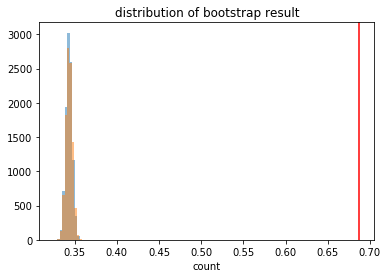

In [83]:
# distribution of bootsrap result
plt.hist(boot_0_1st, alpha = 0.5, label = 'cluster 0');
plt.hist(boot_1_1st, alpha = 0.5, label = 'cluster 1');
plt.axvline(present_mean, color = 'red');
plt.title('distribution of bootstrap result');
plt.xlabel('proporsion');
plt.xlabel('count');
# boot_1_1st.hist(label = 'cluster 1')

In [84]:
# p value calculation
diff = boot_0_1st - boot_1_1st

up_bound_1 = present_mean
low_bound_1 = 0 - (present_mean - 0)

p_val_1 = (diff>up_bound_1).sum() + (diff<low_bound_1).sum()
p_val_1

0

### A/B test cluster 0 and cluster 2

In [85]:
present_mean_2 = conv_rate_0 - conv_rate_2
present_mean_2

0.20300305205903785

In [86]:
# compare cluster 0 and 1
ab_2nd = (conv_rate_0-conv_rate_2)/2
boot_0_2nd = np.random.binomial(trial_0, ab_2nd, 10000)/trial_0
boot_2_2nd = np.random.binomial(trial_2, ab_2nd, 10000)/trial_2

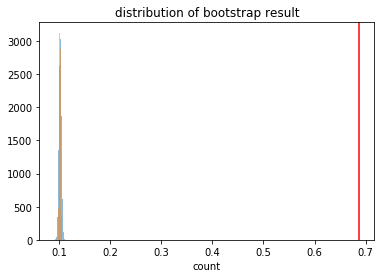

In [87]:
# distribution of bootsrap result
plt.hist(boot_0_2nd, alpha = 0.5, label = 'cluster 0');
plt.hist(boot_2_2nd, alpha = 0.5, label = 'cluster 2');
plt.axvline(present_mean, color = 'red');
plt.title('distribution of bootstrap result');
plt.xlabel('proporsion');
plt.xlabel('count');
# boot_1_1st.hist(label = 'cluster 1')

In [88]:
# p value calculation
diff_2 = boot_0_2nd - boot_2_2nd

up_bound_2 = present_mean_2
low_bound_2 = 0 - (present_mean_2 - 0)

p_val_2 = (diff_2>up_bound_2).sum() + (diff_2<low_bound_2).sum()
p_val_2

0

P value calculation resulted 0. This means cluster 0 is statistically significance over cluster 2. 

Based on 2 A/B test results, there are no reason to reject that cluster 0 is statistically signicant over the other cluster. And offers in that cluster are proved as highest completed offers.

### Get characteristics of high rate completed offers

In [89]:
# join pipeline_offer dataframe and pf dataframe
joined_hr = pd.merge(exp_pf, pipeline_offer,  how='left', left_on= ['id'], right_on = ['offer id'])

In [90]:
joined_hr[joined_hr.cluster==0]

,difficulty,duration,id,offer_type,reward,email,mobile,social,web,offer id,offer_received,offer_viewed,offer_completed,exactly_completed,complete_percentage,cluster
5,7,7,6,discount,3,1,1,1,1,6,7646,7337,5156,5156,67.433952,0
6,10,10,7,discount,2,1,1,1,1,7,7597,7327,5317,5317,69.988153,0


 I can make a conclution that offer with discount has the highest completed percentage than the others. Both offers also using all platforms to announce (email, mobile, social, web). Since the reward are small, offers with discount type and announce in all platform will be good plan to make an offer to get best conversion. 

`2. Which customer segment that give good response campaign?`

### Find customer segment which gives good response to offer

In [91]:
camp_pl['exactly_completed'] = pd.DataFrame([camp_pl['offer_viewed'], camp_pl['offer_completed']]).min()
camp_pl['conversion_rate'] = camp_pl['exactly_completed'] / camp_pl['offer_received']
camp_pl.head(50)

,person,offer id,offer_received,offer_viewed,offer_completed,exactly_completed,conversion_rate
0,1,1,1,1,1,1,1.000000
1,1,4,1,1,1,1,1.000000
2,1,8,1,1,0,0,0.000000
3,1,9,1,1,1,1,1.000000
4,2,3,1,1,0,0,0.000000
5,2,5,3,2,0,0,0.000000
6,2,8,1,0,0,0,0.000000
7,3,3,1,0,0,0,0.000000
8,3,4,1,1,1,1,1.000000
9,3,7,1,1,1,1,1.000000


In [92]:
person_grouping = camp_pl.groupby('person').mean()['conversion_rate'].reset_index()

I will make a boundaries for filtering succesnes of offers. It said that offer to person is success if conversion rate for person is more than 0.5. 

In [93]:
filt_customer = person_grouping[person_grouping.conversion_rate > 0.5]
filt_customer.head(30)

,person,conversion_rate
0,1,0.750000
5,6,0.875000
8,9,0.600000
15,16,0.666667
16,17,0.750000
19,20,0.600000
22,23,0.600000
24,25,0.666667
26,27,0.833333
28,29,0.625000


In [94]:
# merge offer completed data with user profile
filtered_merge = pd.merge(filt_customer, exp_prof,  how='inner', left_on= ['person'], right_on = ['id'])
filtered_merge.head()

,person,conversion_rate,age,became_member_on,gender,id,income,year_member_on
0,6,0.875000,68,2018-04-26,M,6,70000.0,2018
1,9,0.600000,65,2018-02-09,M,9,53000.0,2018
2,16,0.666667,62,2016-02-11,F,16,71000.0,2016
3,17,0.750000,49,2014-11-13,M,17,52000.0,2014
4,20,0.600000,61,2018-05-01,F,20,40000.0,2018


In [95]:
# separate customer into male and female
filtered_merge_f = filtered_merge[filtered_merge.gender == 'F']
filtered_merge_m = filtered_merge[filtered_merge.gender == 'M']
[filtered_merge_f.shape, filtered_merge_m.shape]

[(1699, 8), (2411, 8)]

male customers gives more good responses on given offer. Male customers which completed offer are 712 more than female customers. Gender factors gives significant result on offer completition.

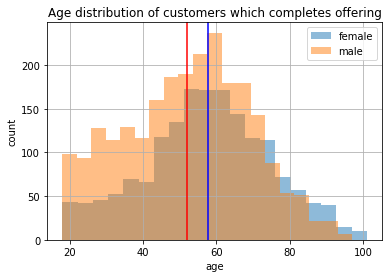

In [96]:
# Show age distribution in male and female customers
filtered_merge_f.age.hist(bins=20, alpha = 0.5, label = 'female');
filtered_merge_m.age.hist(bins=20, alpha = 0.5, label = 'male');
plt.axvline(filtered_merge_f.age.mean(), color = 'blue')
plt.axvline(filtered_merge_m.age.mean(), color = 'red')
plt.title('Age distribution of customers which completes offering');
plt.xlabel('age');
plt.ylabel('count');
plt.legend();

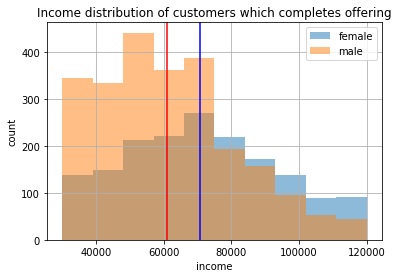

In [97]:
# Show income distribution in male and female customers
filtered_merge_f.income.hist(alpha = 0.5, label = 'female');
filtered_merge_m.income.hist(alpha = 0.5, label = 'male');
plt.axvline(filtered_merge_f.income.mean(), color = 'blue')
plt.axvline(filtered_merge_m.income.mean(), color = 'red')
plt.title('Income distribution of customers which completes offering');
plt.xlabel('income');
plt.ylabel('count');
plt.legend();

Customers age range in which completes the offer are different in male and female. Suggested, focus the offer on male customers in age range between 40 - 70 years old. For female customers, suggested give the offering into age range between 50 - 65 years old.

In the other hand, male costumers mean is less than female customers mean. Male customers which have salary around 40.000 - 75.000 reacting good on the offers. But female customers which reacted on offers have income around 50.000 - 80.000. This phenomenon maybe caused by different needs for male and female. 

### Find customer segment which gives good response to highest completed offer 

In [98]:
# filtering only to offer id 6 and 7
filt_67 = camp_pl[camp_pl['offer id'].isin([6,7])]

# filter person who only completed offer with conversion rate more than 0.5
filt67_grouping = filt_67.groupby('person').mean()['conversion_rate'].reset_index()
filt67_grouping = filt67_grouping[filt67_grouping.conversion_rate > 0.5]

In [99]:
# merge offer completed data with user profile
filt67_merged = pd.merge(filt67_grouping, exp_prof,  how='inner', left_on= ['person'], right_on = ['id'])
# separate customer into male and female
filt67_merged_f = filt67_merged[filt67_merged.gender == 'F']
filt67_merged_m = filt67_merged[filt67_merged.gender == 'M']
[filt67_merged_f.shape, filt67_merged_m.shape]

[(2415, 8), (3342, 8)]

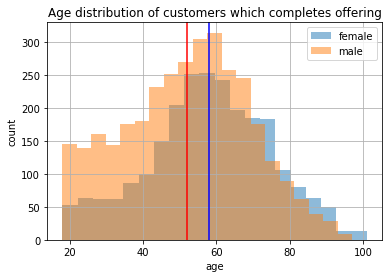

In [100]:
# Show age distribution in male and female customers
filt67_merged_f.age.hist(bins=20, alpha = 0.5, label = 'female');
filt67_merged_m.age.hist(bins=20, alpha = 0.5, label = 'male');
plt.axvline(filt67_merged_f.age.mean(), color = 'blue')
plt.axvline(filt67_merged_m.age.mean(), color = 'red')
plt.title('Age distribution of customers which completes offering');
plt.xlabel('age');
plt.ylabel('count');
plt.legend();

Customers which react with offer id 6 and 7 in total are 5757 with male customers proporsion is around 0.58. Male customers in age range 40 - 70 years old react very well on completing the offer, since female customers age range with good conversion with the offer is shallower, about 50 - 70 years old. 

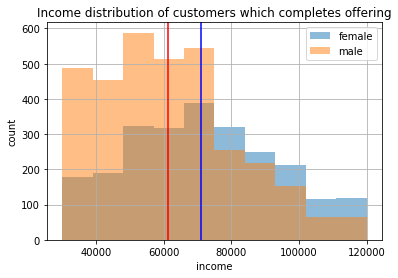

In [101]:
# Show income distribution in male and female customers
filt67_merged_f.income.hist(alpha = 0.5, label = 'female');
filt67_merged_m.income.hist(alpha = 0.5, label = 'male');
plt.axvline(filt67_merged_f.income.mean(), color = 'blue')
plt.axvline(filt67_merged_m.income.mean(), color = 'red')
plt.title('Income distribution of customers which completes offering');
plt.xlabel('income');
plt.ylabel('count');
plt.legend();

Income range for male and female customers which complete offer 6 and 7 is similar with the customers income range who complete all offering.

## Conclusion

1. From 10 offerings, offer with id 6 and 7 give the highest conversion rate and it has statistically significant among the other offers. The completed rate for offer id 6  is around 67.4% and offer id 7 is 69.9%. Suggested for the next advertising plan, it will be good to give offer with discount type and spread it on all platform (web, social media, mobile and email) even the reward are small.

2. Male customers have tendency to complete the offer than female. It is approved by male proporsion who complete the highest completed offer is around 0.58. Suggested to focused on male customers in age range 40 - 70 years old and income in range 40.000 - 75.000. For female customers, recommended age range is around 50 - 70 years old with income in range 50.000 - 80.000.